# Regional Uncertainty Plots

### This notebook is used to demonstrate how to generate regional scale glacier volume uncertainty plots. It uses one technqiue or adding multiple uncertianties, others could be used

#### First, we import ll the necessary analysis packages

In [2]:
# analysis packages
import numpy as np
import pandas as pd
import xarray as xr
import math

# packages for reading files
import glob
import os

# packages for plotting and making things pretty
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)

#### Next, we read the model output files.

##### Side note: due to super computer issues, I processes the data in multiple batches, leading to a large number of files. Ideally, there should be one netcdf file for each RCP

In [5]:
# read files from output directory with specified suffix
filelist = glob.glob(os.path.join('../Output/' , '*9.nc'))

# sort based on RCP
rcp26 = {}
rcp85 = {}

# all specific to my file structure
for f in filelist:
    split = f.split('rcp')
    name = split[2][:-3]
    if name.startswith('26'):
        rcp26[name[3:]] = xr.open_dataset(f)

    elif name.startswith('85'):
        rcp85[name[3:]] = xr.open_dataset(f)

    else:
        print(error)
        
rcps = {'RCP 2.6': rcp26, 'RCP 8.5': rcp85}

85_0to99
85_370to379
85_380to519
85_100to119
85_520to639
85_240to369
85_120to239


### Finding means and error for each RCP

For each RCP,  we have run ensembles of N model runs. So, the code first looks at each glacier in the output file, and reads out N time series of the chosen variable (in this case glacier volume) with one time series for each member of the ensemble.<br><br>
Then, we find the mean and variance. The variance is the square of the standard deviation.<br><br>
We then assume that the spread follows a normal distribution, and so we add the mean and the variance of each glacier together to find the total mean and variance. We can do this because of the following theorum.<br><br>
Theorem: If $X_1, X_2, ... , X_n$ are mutually independent normal random variables with means $\mu_1, \mu_2, ... , \mu_n$ and variances $\sigma_1^2, \sigma_2^2,..., \sigma_n^2$, then the linear combination:

$$\sum_{i=0}^{n} c_iX_i$$

follows the normal distribution:

$$N\left(\sum_{i=0}^{n} c_i\mu_i, \sum_{i=0}^{n} c_i^2\sigma_i^2\right)$$

In [6]:
# variable we are plotting (volume of glacier in this case)
value_to_plot = 'volume_glac_annual'

plot_data = {}

for key,rcp in rcps.items():

    # lists of single glacier means, stds, variances 
    means = []
    stds = []
    variances = []

    #for each dataset in our database
    # (this should be 1 file ideally, I have multiple)
    for name, ds in rcp.items():

        #for each glacier in the database
        for glac in ds.glac_idx.values:

            # a list of each of the time series
            series = []

            #for each model in ensemble:
            for sim in ds.sim.values:

                ts = ds[value_to_plot].sel(glac_idx=glac, sim=sim).to_series()
                series.append(ts)

            #create a dataframe of all series
            df = pd.concat(series, axis=1)

            #find individual glacier mean and std, variance
            mean = df.mean(axis=1)
            std = df.std(axis=1)
            var = df.var(axis=1)

            means.append(mean)
            stds.append(std)
            variances.append(var)

    # now, find total mean and variance, std
    total_mean = sum(means)
    total_variance = sum(variances)
    total_std = total_variance.apply(math.sqrt)
    
    plot_data[key] = {'mean':total_mean, 'std': total_std,
                      'variance': total_variance}     

### Plotting Uncertainty

#### Plotting glacier evolution for muliple RCPs

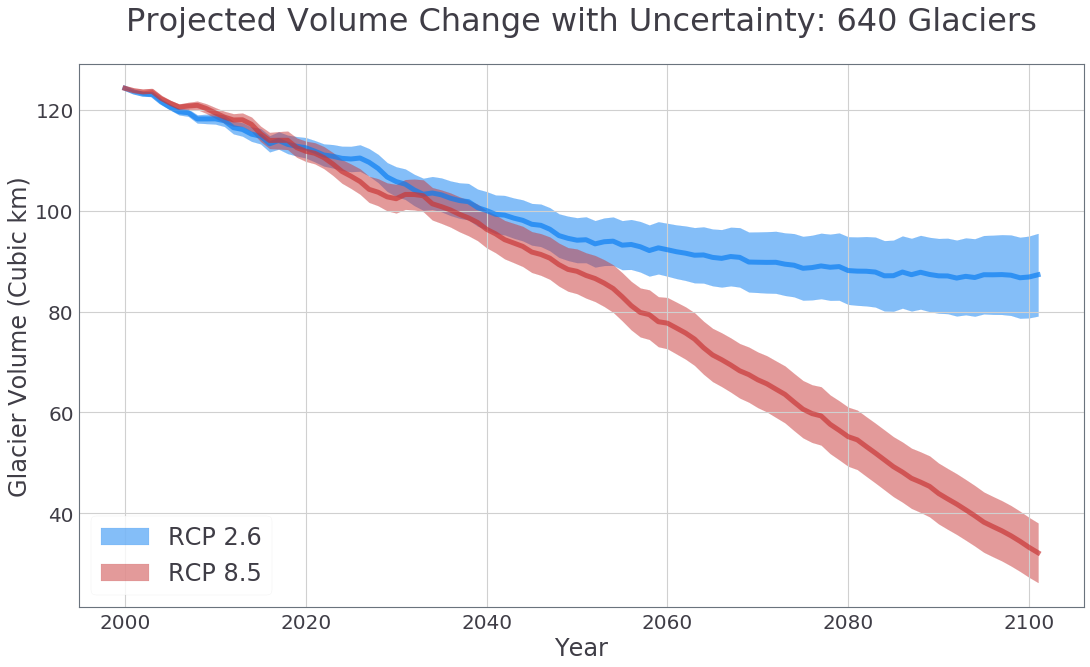

../uncertainty_plots_regional/640glaciers.png


In [15]:
# how many standard deviations of error we want to show
# this could be reconfigured to a percentage based on application
num_stds = 2

# colors used
line_colors = ['#0B7EF2', '#C93737', '#63c30f', '#2E90FF', '#4C0099', '#CC6600']
shade_colors = ['#0B7EF2', '#C93737', '#CEF6AB', '#B3E6FC', '#DCB3FC', '#FFD9A8']

# level of shading for uncertainty plots
alpha = 0.7
s_alpha = 0.5

# do the plotting
fig = plt.figure()

# for each RCP
i = 0

for key, data in plot_data.items():
    
    # get the data
    mean = data['mean']
    std = data['std']

    #plot mean line
    plt.plot(mean, color=line_colors[i], linewidth=5, alpha=alpha)
    
    #plot error region
    plt.fill_between(std.index, mean-(num_stds*std),
                     mean+(num_stds*std), label=key,
                     color=shade_colors[i], alpha=s_alpha)
    
    i += 1

            
# niceties
plt.title('Projected Volume Change with Uncertainty: 640 Glaciers', fontsize = 32, y=1.05)
plt.ylabel('Glacier Volume (Cubic km)', fontsize =24)
plt.xlabel('Year', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(loc='lower left', fontsize=24)

plt.show()
print('../uncertainty_plots_regional/640glaciers.png')

#fig.savefig('../uncertainty_plots_regional/640glaciers.png')